## Environment Setup (Drive Mount & Project Clone)

In [ ]:
# ============================
# 1. Mount Google Drive (optional)
# ============================
from google.colab import drive
drive.mount('/content/drive')

# ============================
# 2. 기본 작업 디렉토리 설정
# ============================
import os
from pathlib import Path

base_dir = Path("/content/drive/MyDrive/Colab Notebooks")
os.makedirs(base_dir, exist_ok=True)
%cd {base_dir}

# ============================
# 3. Repository clone or skip
# ============================
repo_url = "https://github.com/seo-1004/cv-team5-anomaly-detection.git"
repo_dir = base_dir / "cv-team5-anomaly-detection"

if not repo_dir.exists():
    print("Repository not found. Cloning...")
    !git clone {repo_url}
else:
    print("Repository already exists. Skipping clone.")

%cd {repo_dir}

# ============================
# 4. Model checkpoint 확인 후 setup.sh 실행
# ============================
model_path = "checkpoints/autoencoder/best_model_epoch_100.pth"

if not os.path.exists(model_path):
    print("Model not found. Running setup.sh to download/setup model...")
    !bash setup.sh
else:
    print("Model already exists. Skipping setup.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks
Repository already exists. Skipping clone.
/content/drive/MyDrive/Colab Notebooks/cv-team5-anomaly-detection
Model already exists. Skipping setup.


## Runtime info and device setup

In [ ]:
# Runtime info and device setup
import os
import sys
import glob
import torch

# Project-specific imports
from src.data_generation import generate_normals_for_objects, generate_anomalies_for_objects
from src.dataprep import NormalMapDataset
from src.autoencoder import train_autoencoder, load_model
from src.evaluation import evaluate_model, show_results

print('-' * 126)
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")

# Select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


------------------------------------------------------------------------------------------------------------------------------
Python Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch Version: 2.9.0+cpu
Device: cpu


## Data Paths

In [ ]:
# Data directory setup
BASE_DIR = base_dir / "cv-team5-anomaly-detection"
%cd {BASE_DIR}

RAW_DATA_DIR = "data/raw/diligent/pmsData"

obj_list = [
    'ballPNG', 'catPNG', 'cowPNG', 'bearPNG', 'buddhaPNG',
    'gobletPNG', 'harvestPNG', 'pot1PNG', 'pot2PNG', 'readingPNG'
]

obj_dirs = [os.path.join(RAW_DATA_DIR, d) for d in obj_list]

normal_dir = BASE_DIR / "data" / "processed" / "normals"
normal_dir.mkdir(parents=True, exist_ok=True)

anomalies_dir = BASE_DIR / "data" / "processed" / "anomalies"
anomalies_dir.mkdir(parents=True, exist_ok=True)


/content/drive/MyDrive/Colab Notebooks/cv-team5-anomaly-detection


## Data Generation

### 1) Normal Map Check (N_*.npy) and Generation if Missing

In [ ]:
# -------------------------------------------------------------------
# 1) Normal Map Check (N_*.npy) and Generation if Missing
# -------------------------------------------------------------------
normal_files = sorted(glob.glob(os.path.join(normal_dir, "N_*.npy")))

if len(normal_files) == 0:
    print("[Normal] No N_*.npy files found. Generating new normal maps...")
    generate_normals_for_objects(RAW_DATA_DIR, normal_dir, obj_list)
    normal_files = sorted(glob.glob(os.path.join(normal_dir, "N_*.npy")))
    print(f"[Normal] Generation completed: {len(normal_files)} files created.")
else:
    print(f"[Normal] Using existing normal maps: {len(normal_files)} files.")


[Normal] Using existing normal maps: 138 files.


### 2) Anomaly Data Check (A_*.npy, M_*.npy) and Generation if Missing

In [ ]:
# -------------------------------------------------------------------
# 2) Anomaly Data Check (A_*.npy, M_*.npy) and Generation if Missing
# -------------------------------------------------------------------
anom_A_files = sorted(glob.glob(os.path.join(anomalies_dir, "A_*.npy")))
anom_M_files = sorted(glob.glob(os.path.join(anomalies_dir, "M_*.npy")))

if len(anom_A_files) == 0 or len(anom_M_files) == 0:
    print("[Anomaly] No A_*.npy or M_*.npy files found. Generating new anomaly data...")
    generate_anomalies_for_objects(normal_dir, RAW_DATA_DIR, anomalies_dir)
    anom_A_files = sorted(glob.glob(os.path.join(anomalies_dir, "A_*.npy")))
    anom_M_files = sorted(glob.glob(os.path.join(anomalies_dir, "M_*.npy")))
    print(f"[Anomaly] Generation completed: A = {len(anom_A_files)}, M = {len(anom_M_files)}")
else:
    print(f"[Anomaly] Using existing anomaly data: A = {len(anom_A_files)}, M = {len(anom_M_files)}")


[Anomaly] Using existing anomaly data: A = 30, M = 30


## Dataset Initialization

In [ ]:
# Dataset initialization

train_dataset = NormalMapDataset(
    data_dir=normal_dir,     # Directory containing N_*.npy normal maps
    prefix='N',              # Prefix identifying normal map files
    has_mask=False,          # Normal maps do not include masks
    size=(256, 256)          # Spatial resolution for input tensors
)

anom_dataset = NormalMapDataset(
    data_dir=anomalies_dir,  # Directory containing A_*.npy anomaly maps
    prefix='A',              # Prefix identifying anomaly map files
    has_mask=True,           # Anomaly samples provide masks (M_*.npy)
    size=(256, 256)          # Spatial resolution for input tensors
)


## Training Configuration

In [ ]:
# ---------------------------------------------------------
# Training Configuration
# ---------------------------------------------------------
# Set train_mode to True to train the model and save the checkpoint.
# Set train_mode to False to load a pretrained model from disk.
# ---------------------------------------------------------

train_mode =  False

model_path = 'checkpoints/autoencoder/best_model_epoch_100.pth'

if train_mode:
    print("🟢 Training mode: Starting model training...")
    model, device, best_val_loss = train_autoencoder(
        dataset=train_dataset,
        learning_rate=5e-4,
        batch_size=8,
        epochs=100,
        val_split=0.2,
        num_workers=2,
        model_save_path=model_path,
        loss_fn="mse",
    )
    print(f"Training completed. Best validation loss: {best_val_loss}")

else:
    print("🔵 Load mode: Loading pretrained model...")
    model, device = load_model(model_path)
    print("Model successfully loaded.")


🔵 Load mode: Loading pretrained model...
[load_model] 모델 로드 완료: checkpoints/autoencoder/best_model_epoch_100.pth
[load_model] device: cpu
Model successfully loaded.


## Evaluation

In [ ]:
# Directory to save evaluation results
results_dir = BASE_DIR / "results"

# Run evaluation on anomaly dataset
auroc, vis_data = evaluate_model(
    model=model,
    dataset=anom_dataset,
    device=device,
    max_vis_samples=4,
    save_dir=results_dir
)

print(f"Pixel-level AUROC: {auroc:.4f}")


모든 결과 저장 완료!
Pixel-level AUROC: 0.9546


## Visualization

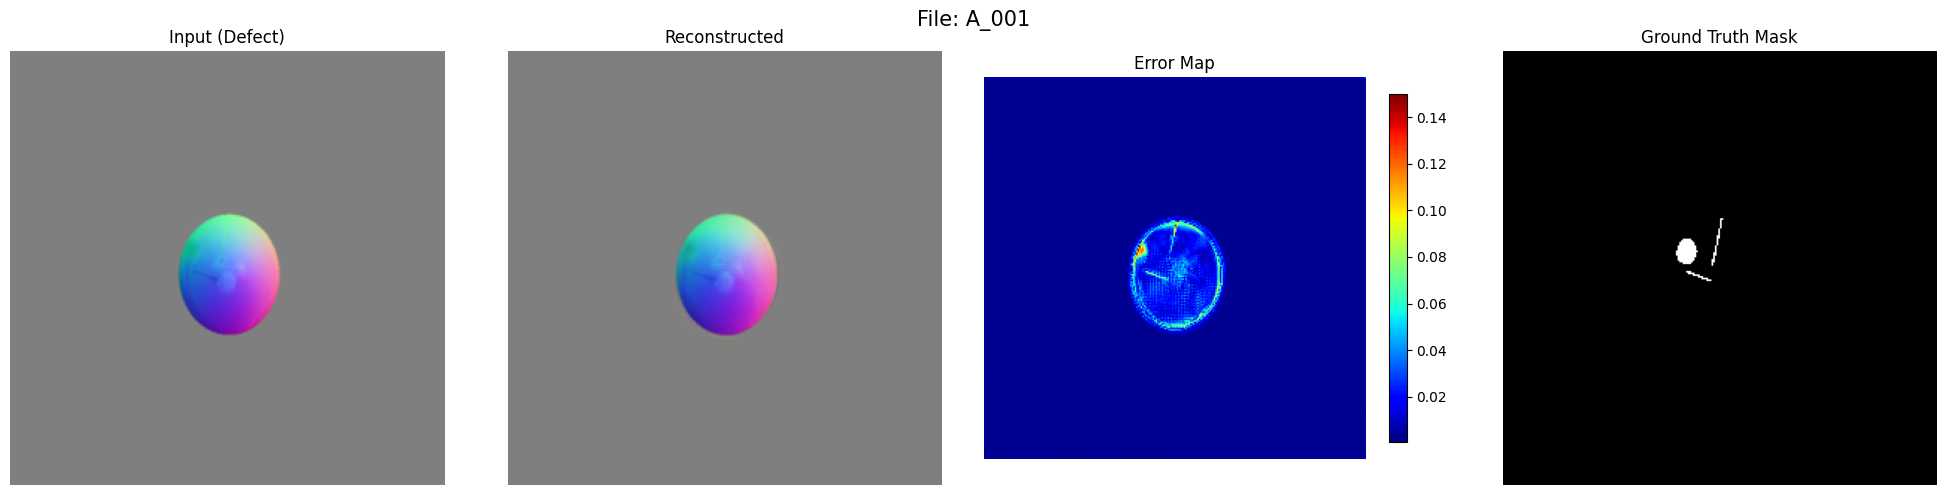

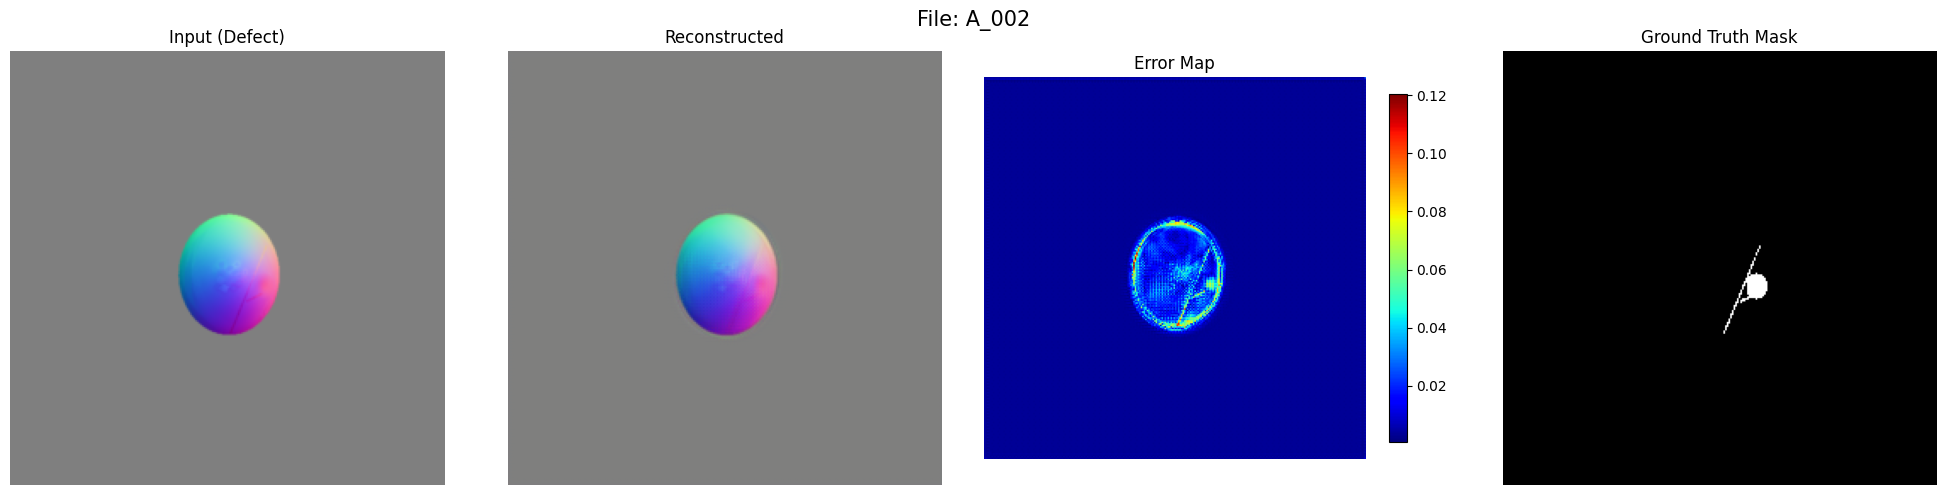

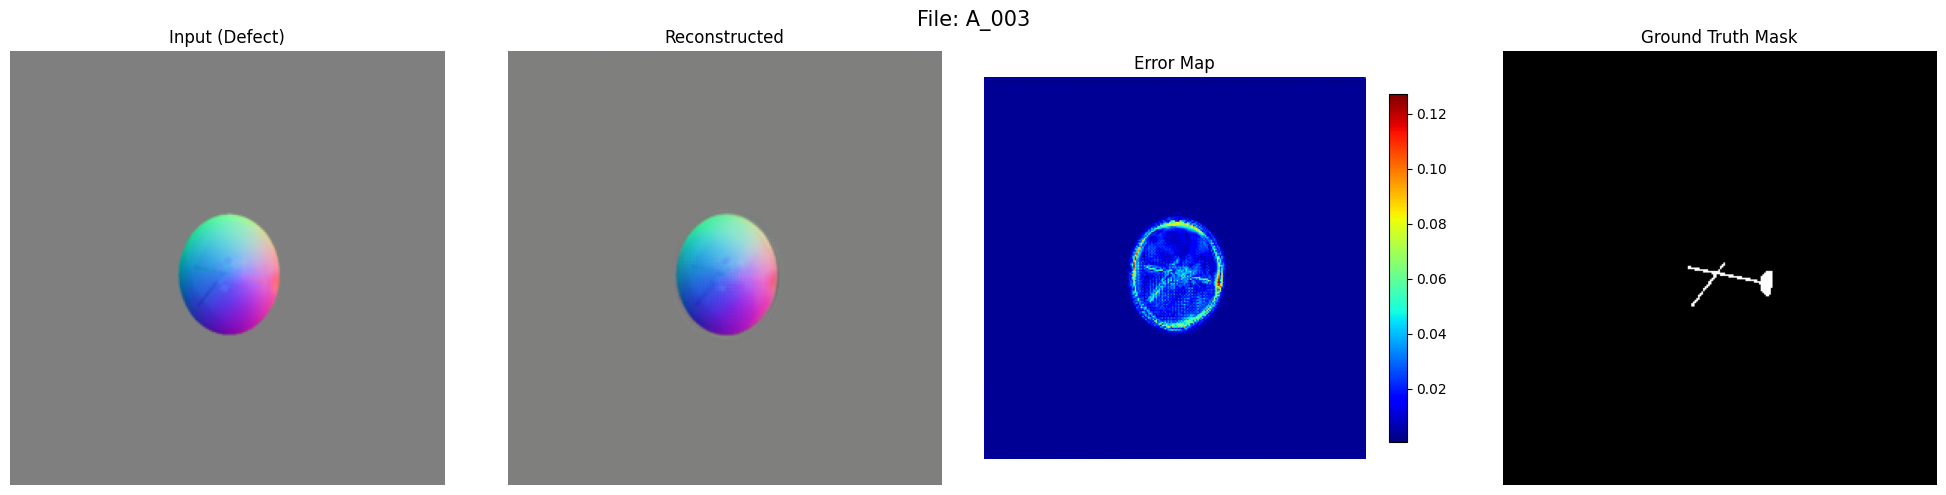

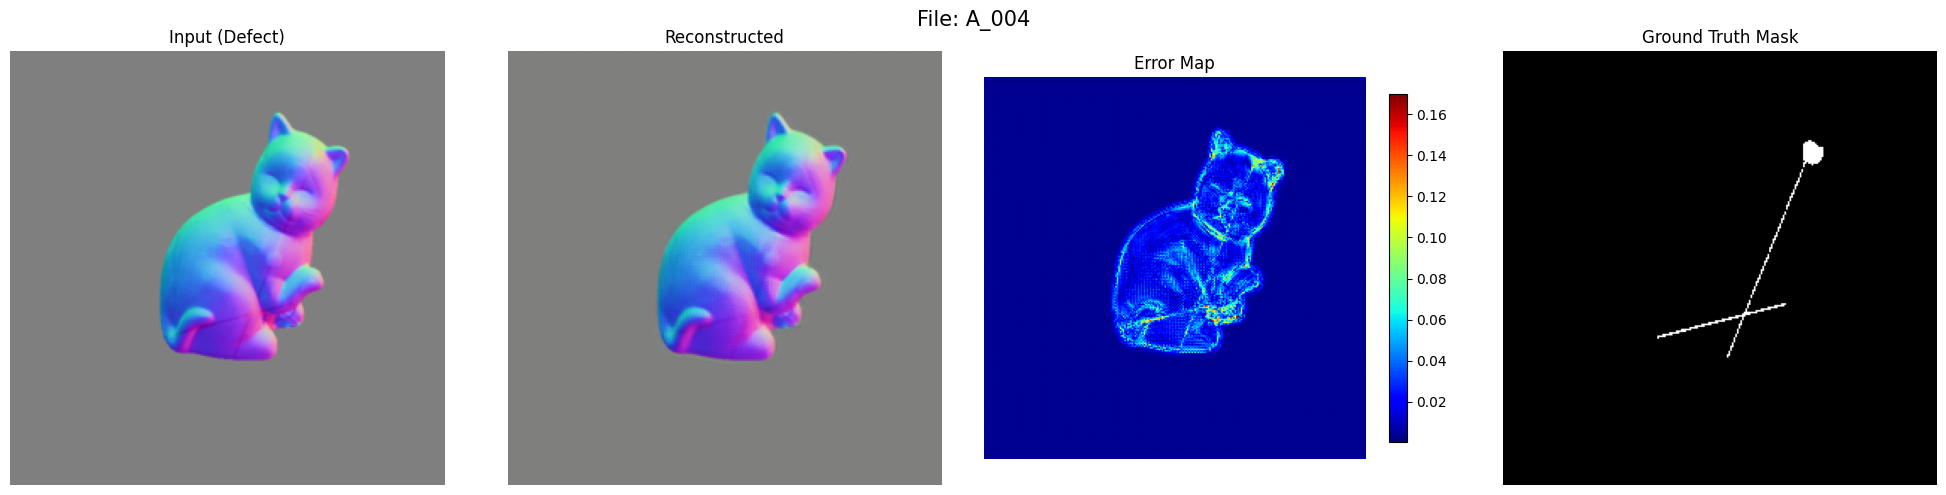

In [ ]:
# -------------------------------------------------------------------
# Visualization
# -------------------------------------------------------------------

# Display reconstruction results and anomaly score maps generated during evaluation.
show_results(vis_data)